# Spot-checking inicial: Árvore de Decisão

As árvores de decisão são conhecidas por possuírem um baixo viés, ao mesmo tempo em que apresentam alta variância.
Isto é, o método é capaz de modelar fronteiras de decisão bastante complexas, o que, por um lado, é positivo, mas torna o algoritmo bastante suscetível a ruído ou a padrões nos dados de treino que não generalizam para instâncias de teste.
Por isso, técnicas de poda são fundamentais para o uso efetivo do modelo em dados novos.

Nessa atividade, iremos analisar como a estrutura e as predições da árvore de decisão são afetadas por pequenas variações no conjunto de treino. Além disso, veremos duas técnicas de poda que podem ser usadas para controlar a complexidade do modelo.

## Carregamento dos Dados

### Obtenção e análise dos dados
O código abaixo carrega o dataset utilizando as funções do scikit-learn e mostra algumas informações básicas sobre os dados

In [21]:
import pandas as pd

In [22]:
df_sinan_processed = pd.read_csv("../data/processed/processed-full-numeric.csv")

In [23]:
# Matriz de atributos
X = df_sinan_processed.drop("severity", axis=1)

# Vetor alvo
y = df_sinan_processed["severity"]

feature_names = X.columns.tolist()
target_names = ["low_risk", "alarm", "severe"]

# Mapeamento dos rótulos alvo para inteiros (por conveniência)
target_mapping = {name: idx for idx, name in enumerate(target_names)}
y = y.map(target_mapping)

In [4]:
from collections import Counter 

# Contagem do número de exemplos em cada classe
class_counts = Counter(y)
for target_class, count in class_counts.items():
    print(f"Número de exemplos na classe '{target_class}' ({target_names[target_class]}): {count}")

Número de exemplos na classe '0' (low_risk): 420845
Número de exemplos na classe '1' (alarm): 318190
Número de exemplos na classe '2' (severe): 31363


## Variância nas Árvores de Decisão


### Analisando a Estrutura das Árvores de Decisão


Como estudado em aula, a árvore de decisão é conhecida por ser um classificador com alta variância. Isso possui consequências na estrutura das árvores treinadas.

O código abaixo treina várias árvores de decisão com diferentes conjuntos de treino obtidos através do método holdout.


In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

def get_root_node(dt, feature_names):
    feature_idx = dt.tree_.feature[0]
    return feature_names[feature_idx]

n_repeats = 5
root_nodes = []

# Variando o seed do holdout, geramos diferentes conjuntos de treino/teste
for split_random_state in range(0, n_repeats):
  # Holdout com 20% de teste
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=split_random_state)

  # Treinamento da árvore de decisão
  dt = DecisionTreeClassifier(random_state=0)
  dt.fit(X_train, y_train)

  # Obtemos o atributo usado na raiz e o salvamos na lista
  root_node = get_root_node(dt, feature_names)
  root_nodes.append(root_node)

root_nodes

['apresenta_leucopenia']

### Analisando a Acurácia das Árvores de Decisão

A propriedade de variância também implica em efeitos na variabilidade da performance dos modelos.
Podemos usar a acurácia como medida de performance, o que pode ser feito também através do scikit-learn. Posteriormente estudaremos outras métricas de desempenho que são mais indicadas para problemas em que o número de instâncias por classe é desbalanceado, como é o caso deste conjunto de dados.

In [8]:
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Acurácia nos dados de teste: %.3f" % accuracy)

Acurácia nos dados de teste: 0.970


O código abaixo executa repetidas vezes o treinamento das árvores de decisão, da mesma forma que no item *Analisando a Estrutura das Árvores de Decisão*.

**Atenção: Não mude os valores que estão sendo passados para os parâmetros random_state para garantir a reprodutibilidade do código**.


In [9]:
import numpy as np

accuracies = []

for split_random_state in range(0, n_repeats):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=split_random_state)

  dt = DecisionTreeClassifier(random_state=0)
  
  dt.fit(X_train, y_train)

  # Avaliação da acurácia nos dados de teste
  y_pred = dt.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  accuracies.append(accuracy)

# Cálculo das estatísticas descritivas
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
max_accuracy = np.max(accuracies)
min_accuracy = np.min(accuracies)

print(f"Acurácia média: {mean_accuracy:.3f}")
print(f"Desvio padrão: {std_accuracy:.3f}")
print(f"Acurácia máxima: {max_accuracy:.3f}")
print(f"Acurácia mínima: {min_accuracy:.3f}")


Acurácia média: 0.970
Desvio padrão: 0.000
Acurácia máxima: 0.970
Acurácia mínima: 0.970


## Observando o Efeito da Poda

As árvores de decisão treinadas nos itens anteriores não possuíam nenhuma forma de poda. No entanto, é possível utilizar técnicas de poda através do scikit-learn. Como consequência, elas podem ter uma complexidade além do que é necessário na modelagem do problema.



### Exemplo de Pré-poda: profundidade máxima da árvore
Podemos especificar a profundidade máxima da árvore utilizando o hiperparâmetro max_depth. Veja como exemplo o código abaixo.

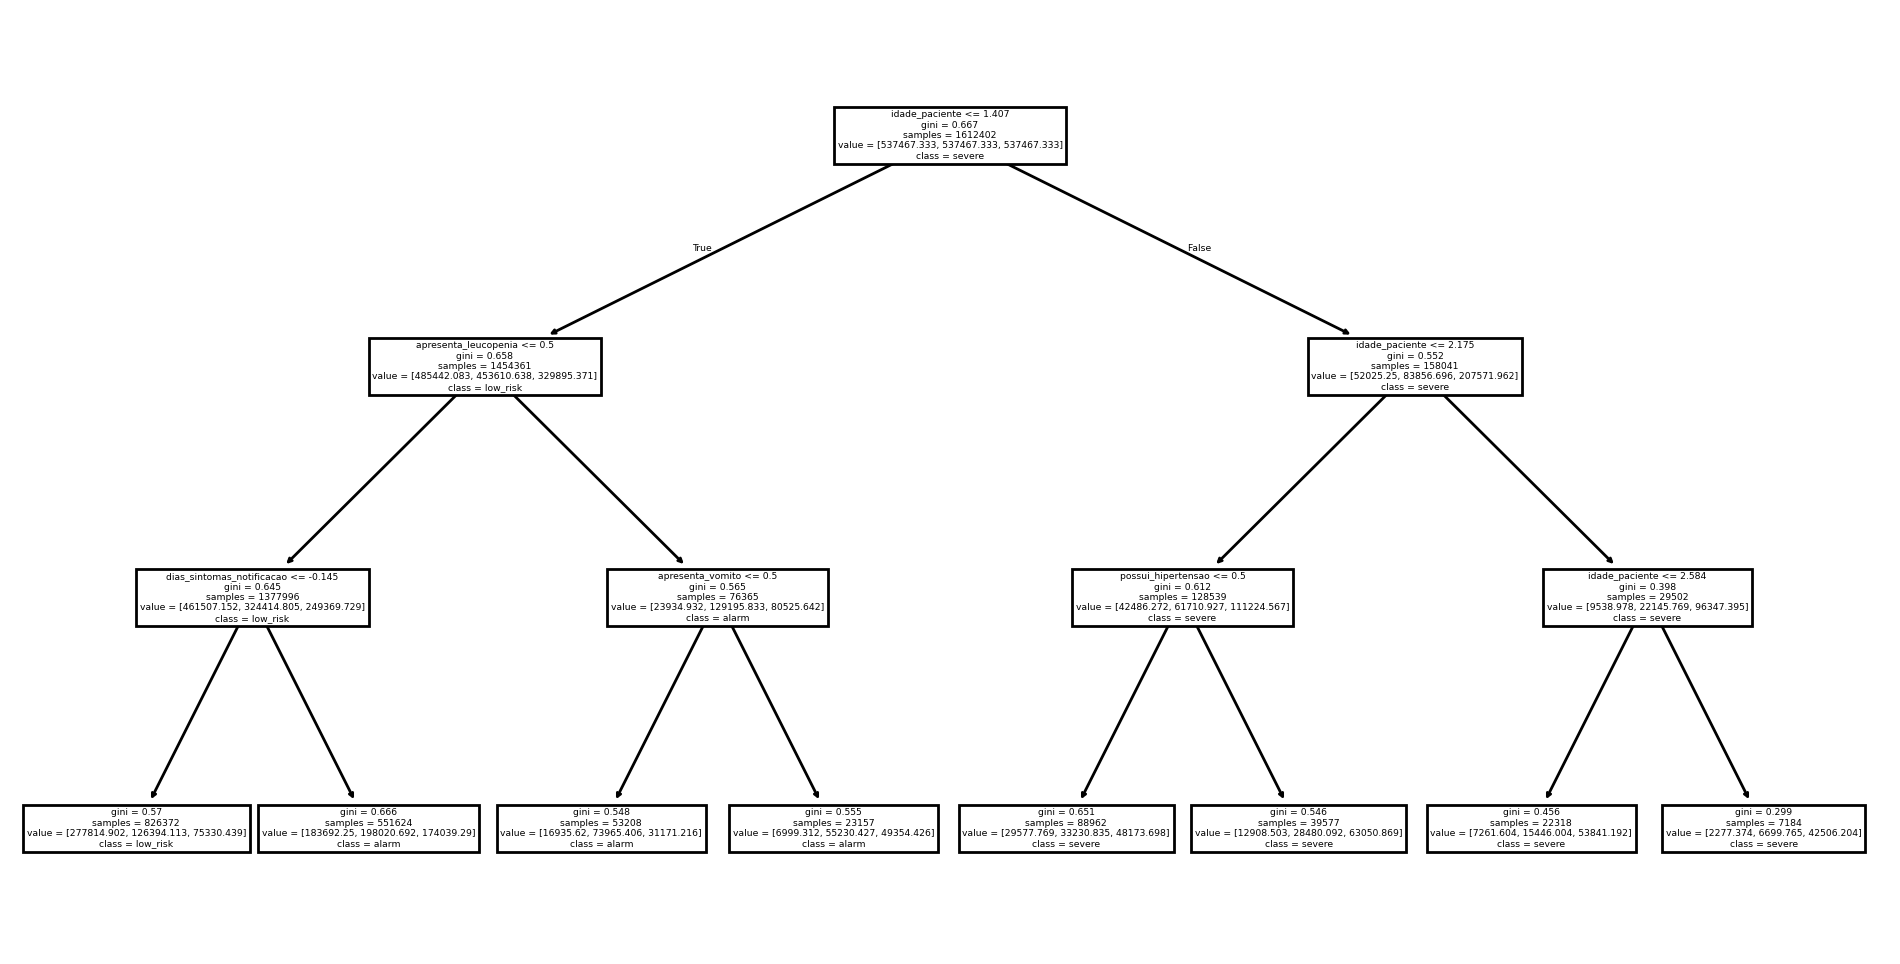

In [10]:
import matplotlib.pyplot as plt

dt = DecisionTreeClassifier(max_depth=3, class_weight='balanced')
dt.fit(X, y)

from sklearn.tree import plot_tree
plt.figure(figsize=(12,6), dpi=200)
_ = plot_tree(dt, feature_names=feature_names, class_names=target_names)

O código abaixo gera árvores de decisão com diferentes profundidades máximas e as avalia em termos de acurácia.
Observe que todas as árvores são treinadas e avaliadas com os mesmos conjuntos de treino, validação e teste, visto que especificamos o parâmetro $random\_state = 42$.
Com base nesse código, e possíveis modificações que você faça a ele, responda à Questão  4 do questionário.

**Não mude o valor que está sendo passado em random_state**.


In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# Definindo as proporções de treino, validação e teste.
train_ratio = 0.70
test_ratio = 0.15
validation_ratio = 0.15

# Fazendo a primeira divisão, para separar um conjunto de teste dos demais.
# Assuma X_temp e y_temp para os dados de treinamento+validação e X_test e y_test para os de teste
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=test_ratio, random_state=42, stratify=y)

# Fazendo a segunda divisão, para gerar o conjunto de treino e validação a partir
# do conjunto de 'treinamento' da divisão anterior
# Assuma X_train e y_train para os dados de treinamento e X_valid e y_valid para os de teste
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=validation_ratio/(train_ratio+test_ratio), random_state=42, stratify=y_temp)

print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

(539278, 42)
(115560, 42)
(115560, 42)


## Amostragem de Dados

### Amostragem com SMOTE (Sem Undersampling)
Inicialmente, analisamos o desempenho do modelo ao treiná-lo com os dados amostrados utilizando apenas oversampling (algoritmo SMOTE). Nessa etapa, utilizamos o SMOTE para aumentar o número de instância nas classes minoritárias ('alarm' e 'severe') de modo que estas fiquem com o mesmo número de instâncias da classe majoritária ('low_risk').

In [25]:
from imblearn.over_sampling import SMOTE
from collections import Counter

print("Distribuição original do treino:", Counter(y_train))

smote = SMOTE(random_state=42)

# Aplique o SMOTE apenas nos dados de treino
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Distribuição do treino após SMOTE:", Counter(y_train_resampled))

Distribuição original do treino: Counter({0: 294591, 1: 222732, 2: 21955})
Distribuição do treino após SMOTE: Counter({1: 294591, 0: 294591, 2: 294591})


In [26]:
from sklearn.metrics import f1_score

max_depths = [3, 5, 8, 10, 15, 20, 30, 50]
f1_scores_valid = []
f1_scores_train = []

for depth in max_depths:
  dt = DecisionTreeClassifier(max_depth=depth, class_weight='balanced', random_state=0)
  dt.fit(X_train_resampled, y_train_resampled)

  y_pred = dt.predict(X_valid)

  f1_valid = f1_score(y_valid, y_pred, average='macro', zero_division=0)
  f1_scores_valid.append(f1_valid)

  y_pred_train = dt.predict(X_train)
  f1_train = f1_score(y_train, y_pred_train, average='macro', zero_division=0)
  f1_scores_train.append(f1_train)

  print(f"max_depth: {depth}, F1 validação: {f1_valid:.3f}, F1 treino: {f1_train:.3f}")

max_depth: 3, F1 validação: 0.395, F1 treino: 0.397
max_depth: 5, F1 validação: 0.441, F1 treino: 0.442
max_depth: 8, F1 validação: 0.449, F1 treino: 0.453
max_depth: 10, F1 validação: 0.457, F1 treino: 0.463
max_depth: 15, F1 validação: 0.523, F1 treino: 0.544
max_depth: 20, F1 validação: 0.627, F1 treino: 0.674
max_depth: 30, F1 validação: 0.828, F1 treino: 0.926
max_depth: 50, F1 validação: 0.868, F1 treino: 0.977


In [20]:
f1_scores_valid

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

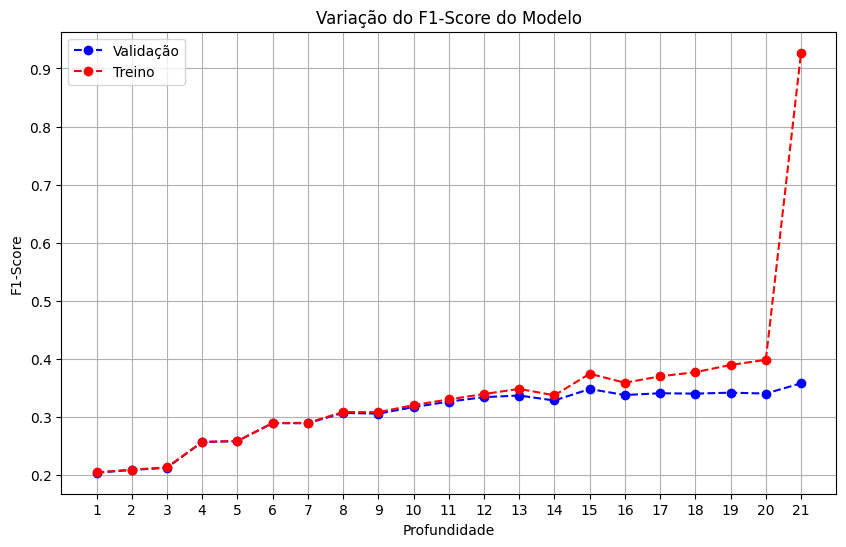

In [28]:
plt.figure(figsize=(10,6))
plt.plot(range(1, len(max_depths)+1), f1_scores_valid, marker='o', linestyle='--', color='b', label='Validação')
plt.plot(range(1, len(max_depths)+1), f1_scores_train, marker='o', linestyle='--', color='r', label='Treino')
plt.title('Variação do F1-Score do Modelo')
plt.xlabel('Profundidade')
plt.ylabel('F1-Score')
plt.xticks(range(1, len(max_depths)+1))
plt.legend()
plt.grid(True)
plt.show()

Para avaliarmos o desempenho do modelo otimizado em novos dados, devemos repetir o treinamento selecionando o melhor valor de hiperparâmetro(s) com base no gráfico anterior, e fazer a avaliação nos dados de teste.
Para melhorar a capacidade de estimar o desempenho do modelo, podemos treinar com os dados de treinamento e validação, tendo em vista que ambos são independentes do conjunto de teste (dados nunca vistos).


In [28]:
# X_train2 = np.concatenate((X_train, X_valid), axis=0)
# y_train2 = np.concatenate((y_train, y_valid), axis=0)

# smote_final = SMOTE(random_state=42)

# X_train_final, y_train_final = smote_final.fit_resample(X_train2, y_train2)

# # Treina e avalia o modelo com valor otimizado de max_depth
# best_max_depth = max_depths[np.argmax(f1_scores_valid)]

# dt = DecisionTreeClassifier(max_depth=best_max_depth, class_weight='balanced', random_state=0)
# dt.fit(X_train_final, y_train_final)

# y_pred = dt.predict(X_test)

# acc_test = accuracy_score(y_test, y_pred)
f1_test = f1_score(y_test, y_pred, average='macro', zero_division=0)
# print(f"Acurácia (Dados de Teste): {acc_test:.3f}")
print(f"F1-Macro (Dados de Teste): {f1_test:.3f}")

F1-Macro (Dados de Teste): 0.891


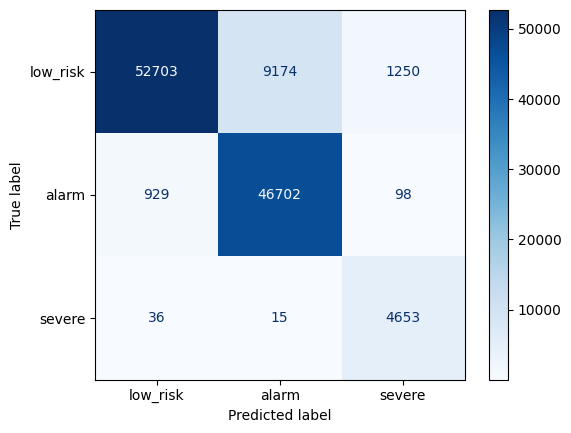

In [29]:
# Plota a matriz de confusão
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=target_names, cmap=plt.cm.Blues)

### Amostragem com Undersampling Aleatório e SMOTE
SMOTE (sozinho) não é a ferramenta ideal para trabalhar com o nosso dataset. A matriz de confusão deixa isso bastante evidente, visto que o número de falsos negativos em instâncias da classe "severe", o qual é um valor que **deve** ser minimizado, é bastante alto (mais alto que o número de verdadeiros positivos). Isso se deve ao fato de o número de exemplos dessa classe ser pequeno demais, em relação ao número total de exemplos do dataset, para aplicar apenas o SMOTE padrão.

A seguir, testamos uma técnica que combina SMOTE (oversampling) com undersampling.

In [13]:
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from collections import Counter

class_counts = Counter(y_train)

print("Distribuição original do treino:", class_counts)

# Step 1: Define the undersampling strategy
under_sampler = RandomUnderSampler(
    sampling_strategy={0: class_counts[1]},
    random_state=42
)

# Step 2: Define the oversampling strategy
over_sampler = SMOTE(
    sampling_strategy={2: class_counts[1] // 2},
    random_state=42
)

# Step 3: Create the pipeline
# IMPORTANT: The pipeline runs in order. Undersampling first, then oversampling
pipeline = Pipeline([
    ('under', under_sampler),
    ('over', over_sampler)
])

X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

print("Distribuição do treino após resampling:", Counter(y_train_resampled))

Distribuição original do treino: Counter({0: 294591, 1: 222732, 2: 21955})
Distribuição do treino após resampling: Counter({0: 222732, 1: 222732, 2: 111366})


In [15]:
from sklearn.metrics import f1_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier

max_depths = [3, 5, 8, 10, 15, 20, 30, 50]
min_samples_leaf_values = [1, 5, 10, 15, 20, 50, 100]

f1_scores_valid = []
f1_scores_train = []

max_f1 = 0
best_max_depth = None
best_min_samples_leaf = None

for depth in max_depths:
    for min_samples in min_samples_leaf_values:
        dt = DecisionTreeClassifier(
            max_depth=depth, min_samples_leaf=min_samples, class_weight='balanced', random_state=0
        )
        dt.fit(X_train_resampled, y_train_resampled)

        y_pred = dt.predict(X_valid)

        f1_valid = f1_score(y_valid, y_pred, average='macro', zero_division=0)
        f1_scores_valid.append(f1_valid)

        y_pred_train = dt.predict(X_train)
        f1_train = f1_score(y_train, y_pred_train, average='macro', zero_division=0)
        f1_scores_train.append(f1_train)

        print(f"Depth: {depth}, F1-Score Validação: {f1_valid:.3f}, F1-Score Treino: {f1_train:.3f}")

        if f1_valid > max_f1:
            max_f1 = f1_valid
            best_max_depth = depth
            best_min_samples_leaf = min_samples


Depth: 3, F1-Score Validação: 0.395, F1-Score Treino: 0.397
Depth: 3, F1-Score Validação: 0.395, F1-Score Treino: 0.397
Depth: 3, F1-Score Validação: 0.395, F1-Score Treino: 0.397
Depth: 3, F1-Score Validação: 0.395, F1-Score Treino: 0.397
Depth: 3, F1-Score Validação: 0.395, F1-Score Treino: 0.397
Depth: 3, F1-Score Validação: 0.395, F1-Score Treino: 0.397
Depth: 3, F1-Score Validação: 0.395, F1-Score Treino: 0.397
Depth: 5, F1-Score Validação: 0.419, F1-Score Treino: 0.420
Depth: 5, F1-Score Validação: 0.419, F1-Score Treino: 0.420
Depth: 5, F1-Score Validação: 0.419, F1-Score Treino: 0.420
Depth: 5, F1-Score Validação: 0.419, F1-Score Treino: 0.420
Depth: 5, F1-Score Validação: 0.419, F1-Score Treino: 0.420
Depth: 5, F1-Score Validação: 0.419, F1-Score Treino: 0.420
Depth: 5, F1-Score Validação: 0.419, F1-Score Treino: 0.420
Depth: 8, F1-Score Validação: 0.451, F1-Score Treino: 0.454
Depth: 8, F1-Score Validação: 0.451, F1-Score Treino: 0.454
Depth: 8, F1-Score Validação: 0.451, F1-

In [118]:
f1_scores_valid

[0.24737865097801426,
 0.2507456324429305,
 0.2546660851343883,
 0.280553287375976,
 0.2808901309962128,
 0.29797198105693196,
 0.2990453388680581,
 0.3220866177667641,
 0.32878597253955816,
 0.329638645963974,
 0.3376938115492572,
 0.3346549911027779,
 0.3409410275006927,
 0.33193274163516984,
 0.33587234237653546]

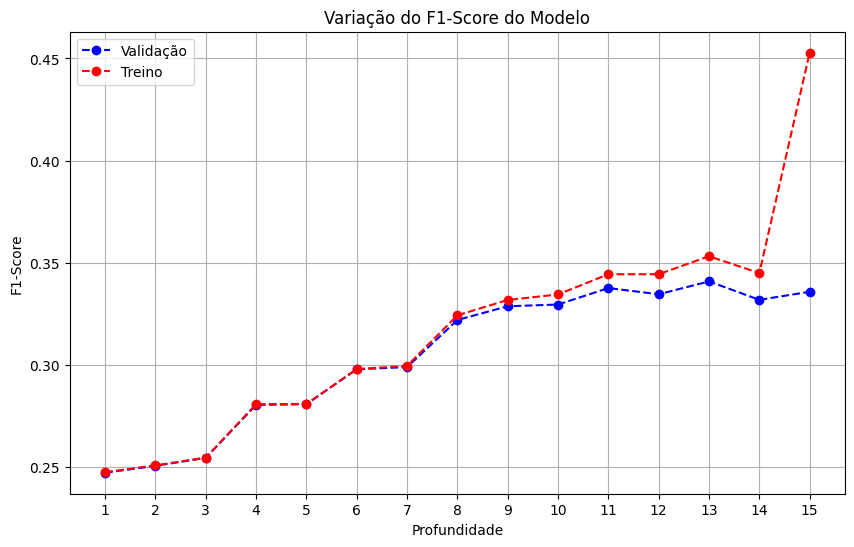

In [ ]:
import matplotlib.pyplot as plt

max_depths_labels = [str(d) if d is not None else '-' for d in max_depths]

plt.figure(figsize=(10,6))
plt.plot(max_depths_labels, f1_scores_valid, marker='o', linestyle='--', color='b', label='Validação')
plt.plot(max_depths_labels, f1_scores_train, marker='o', linestyle='--', color='r', label='Treino')
plt.title('Variação do F1-Score do Modelo')
plt.xlabel('Profundidade')
plt.ylabel('F1-Score')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
import numpy as np

X_train2 = np.concatenate((X_train, X_valid), axis=0)
y_train2 = np.concatenate((y_train, y_valid), axis=0)

class_counts = Counter(y_train2)

under_sampler_final = RandomUnderSampler(
    sampling_strategy={0: class_counts[1]},
    random_state=42
)
over_sampler_final = SMOTE(
    sampling_strategy={2: class_counts[1] // 2},
    random_state=42
)
pipeline_final = Pipeline([
    ('under', under_sampler_final),
    ('over', over_sampler_final)
])

X_train_final, y_train_final = pipeline_final.fit_resample(X_train2, y_train2)

print("Best max_depth:", best_max_depth)
print("Best min_samples_leaf:", best_min_samples_leaf)

dt = DecisionTreeClassifier(
    max_depth=best_max_depth, min_samples_leaf=best_min_samples_leaf, class_weight='balanced', random_state=0
)
dt.fit(X_train_final, y_train_final)

y_pred = dt.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
print(f"Accuracy: {acc:.3f}")
print(f"F1-macro: {f1:.3f}")

Best max_depth: 50
Best min_samples_leaf: 1
Accuracy: 0.887
F1-macro: 0.876


/home/gabriel/Documents/UFRGS/2025-2/ML/TF/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


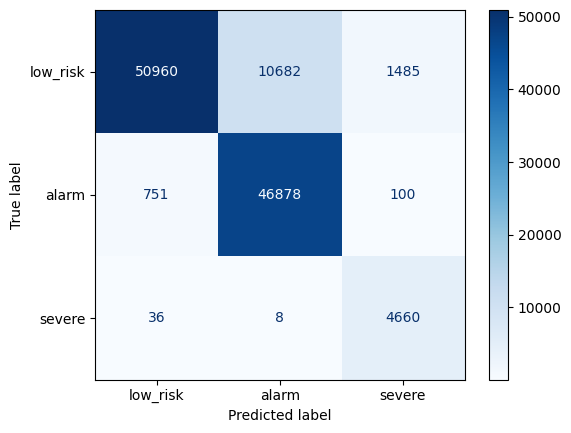

In [18]:
# Plota a matriz de confusão
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=target_names, cmap=plt.cm.Blues)

### Abordagem Alternativa: Hierarquia de Classificadores
Decompõe o problema original (multi-classe) em um hierarquia de problemas de classificação binária.

In [6]:
# Primeiro classificador: classifica entre 'low_risk' e 'high_risk' ('alarm' ou 'severe')
X_c1_train = X_train
X_c1_valid = X_valid
X_c1_test = X_test

target_mapping_c1 = {
    target_mapping[name]: int(name != "low_risk") for name in target_names
}
y_c1_train = y_train.map(target_mapping_c1)
y_c1_valid = y_valid.map(target_mapping_c1)
y_c1_test = y_test.map(target_mapping_c1)

target_names_c1 = ["low_risk", "high_risk"]

print(X_c1_train.shape)
print(X_c1_test.shape)
print(X_c1_valid.shape)

(539278, 42)
(115560, 42)
(115560, 42)


In [7]:
# from imblearn.pipeline import Pipeline
# from imblearn.combine import SMOTETomek
# from collections import Counter

# print("Distribuição original do treino:", Counter(y_c1_train))

# over_sampler = SMOTETomek(
#     random_state=42
# )

# X_c1_train_resampled, y_c1_train_resampled = over_sampler.fit_resample(X_c1_train, y_c1_train)

# print("Distribuição do treino após amostragem:", Counter(y_c1_train_resampled))

X_c1_train_resampled = X_c1_train
y_c1_train_resampled = y_c1_train

In [8]:
from sklearn.metrics import recall_score

max_depths = [3, 5, 8, 10, 15, 20]
min_samples_leaf_values = [1, 5, 10, 15, 20, 50, 100]

# recall_values = []
max_recall = -1
best_max_depth = None
best_min_samples_leaf = None

for depth in max_depths:
    for min_samples_leaf in min_samples_leaf_values:
        dt = DecisionTreeClassifier(
            max_depth=depth, min_samples_leaf=min_samples_leaf, class_weight='balanced', random_state=0
        )
        dt.fit(X_c1_train, y_c1_train)

        y_pred = dt.predict(X_c1_valid)

        recall = recall_score(y_c1_valid, y_pred)
        # recall_values.append(recall)

        print(f"Config ({depth}, {min_samples_leaf}): Recall = {recall}")

        if recall > max_recall:
            best_max_depth = depth
            best_min_samples_leaf = min_samples_leaf


Config (3, 1): Recall = 0.7000171647626495
Config (3, 5): Recall = 0.7000171647626495
Config (3, 10): Recall = 0.7000171647626495
Config (3, 15): Recall = 0.7000171647626495
Config (3, 20): Recall = 0.7000171647626495
Config (3, 50): Recall = 0.7000171647626495
Config (3, 100): Recall = 0.7000171647626495
Config (5, 1): Recall = 0.6064882802815021
Config (5, 5): Recall = 0.6064882802815021
Config (5, 10): Recall = 0.6064882802815021
Config (5, 15): Recall = 0.6064882802815021
Config (5, 20): Recall = 0.6064882802815021
Config (5, 50): Recall = 0.6064119924475044
Config (5, 100): Recall = 0.6064119924475044
Config (8, 1): Recall = 0.6136593366772833
Config (8, 5): Recall = 0.6135830488432857
Config (8, 10): Recall = 0.6136211927602846
Config (8, 15): Recall = 0.6135639768847863
Config (8, 20): Recall = 0.6136021208017851
Config (8, 50): Recall = 0.613506761009288
Config (8, 100): Recall = 0.6136211927602846
Config (10, 1): Recall = 0.6433353041023783
Config (10, 5): Recall = 0.642839433

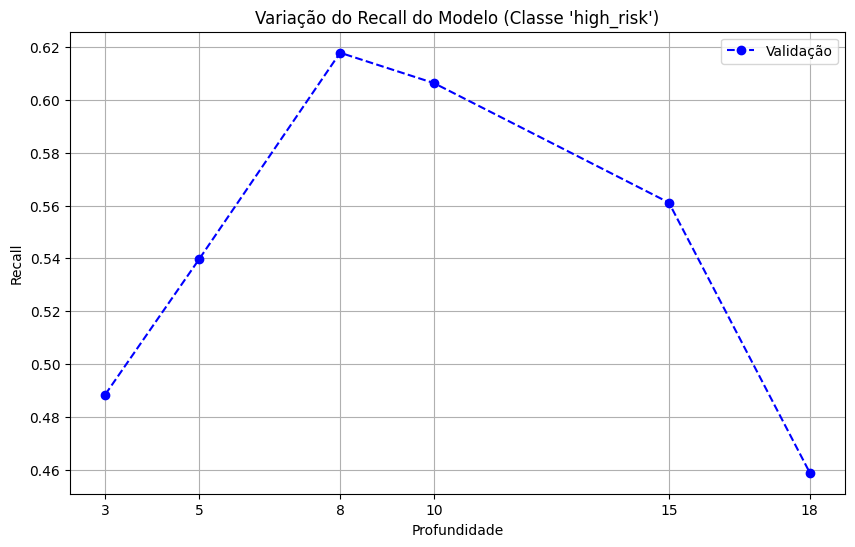

In [ ]:
# Plotar a variação dos F1-scores
# plt.figure(figsize=(10,6))
# plt.plot(max_depths, recall_values, marker='o', linestyle='--', color='b', label='Validação')
# plt.title('Variação do Recall do Modelo (Classe \'high_risk\')')
# plt.xlabel('Profundidade')
# plt.ylabel('Recall')
# plt.xticks(max_depths)
# plt.legend()
# plt.grid(True)
# plt.show()

In [9]:
from sklearn.metrics import classification_report
import numpy as np

X_c1_train_final = np.concatenate((X_c1_train, X_c1_valid), axis=0)
y_c1_train_final = np.concatenate((y_c1_train, y_c1_valid), axis=0)

# under_sampler_final = RandomUnderSampler(
#     sampling_strategy={0: 200000},
#     random_state=42
# )
# over_sampler_final = SMOTE(
#     sampling_strategy={1: 100000},
#     random_state=42
# )
# pipeline_final = Pipeline([
#     ('under', under_sampler_final),
#     ('over', over_sampler_final)
# ])

# X_c1_train_final, y_c1_train_final = pipeline_final.fit_resample(X_c1_train_full, y_c1_train_full)

# best_max_depth = max_depths[np.argmax(recall_values)]
# print(f'Best max depth: {best_max_depth}')

dt_c1 = DecisionTreeClassifier(
    max_depth=best_max_depth, min_samples_leaf=best_min_samples_leaf, class_weight='balanced', random_state=0
)
dt_c1.fit(X_c1_train_final, y_c1_train_final)

y_pred = dt_c1.predict(X_c1_test)

report = classification_report(y_c1_test, y_pred, target_names=target_names_c1)
print(report)

              precision    recall  f1-score   support

    low_risk       0.75      0.73      0.74     63127
   high_risk       0.68      0.70      0.69     52433

    accuracy                           0.72    115560
   macro avg       0.71      0.72      0.72    115560
weighted avg       0.72      0.72      0.72    115560



/home/gabriel/Documents/UFRGS/2025-2/ML/TF/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


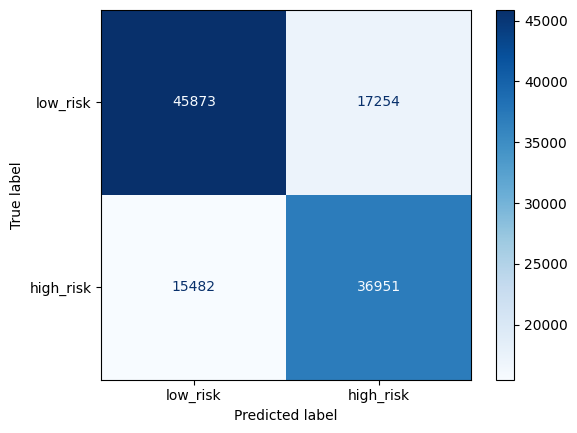

In [10]:
# Plota a matriz de confusão
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(y_c1_test, y_pred, display_labels=target_names_c1, cmap=plt.cm.Blues)

In [10]:
# Segundo classificador: classifica entre 'alarm' e 'severe'
df_train = X_train
df_valid = X_valid
df_test = X_test

df_train["severity"] = y_train
df_valid["severity"] = y_valid
df_test["severity"] = y_test

df_train = df_train[df_train["severity"].isin([1, 2])]
df_valid = df_valid[df_valid["severity"].isin([1, 2])]
df_test = df_test[df_test["severity"].isin([1, 2])]

X_c2_train = df_train.drop("severity", axis=1)
X_c2_valid = df_valid.drop("severity", axis=1)
X_c2_test = df_test.drop("severity", axis=1)

y_c2_train = df_train["severity"]
y_c2_valid = df_valid["severity"]
y_c2_test = df_test["severity"]

target_mapping_c2 = {1: 0, 2: 1}
y_c2_train = y_c2_train.map(target_mapping_c2)
y_c2_valid = y_c2_valid.map(target_mapping_c2)
y_c2_test = y_c2_test.map(target_mapping_c2)

target_names_c2 = ["alarm", "severe"]

print(X_c2_train.shape)
print(X_c2_test.shape)
print(X_c2_valid.shape)

(244687, 42)
(52433, 42)
(52433, 42)


In [11]:
from imblearn.over_sampling import SMOTE
from collections import Counter

print("Distribuição original do treino:", Counter(y_c2_train))

over_sampler = SMOTE(
    random_state=42
)

X_c2_train_resampled, y_c2_train_resampled = over_sampler.fit_resample(X_c2_train, y_c2_train)

print("Distribuição do treino após amostragem:", Counter(y_c2_train_resampled))

Distribuição original do treino: Counter({0: 222732, 1: 21955})
Distribuição do treino após amostragem: Counter({0: 222732, 1: 222732})


In [12]:
from sklearn.metrics import recall_score

max_depths = [5, 8, 10, 15, 20, 25, 30, 50, 75, 100, None]
min_samples_leaf_values = [1, 2, 5, 8, 10, 12, 15, 20, 25]

# recall_values = []
max_recall = -1
best_max_depth = None
best_min_samples_leaf = None

for depth in max_depths:
    for min_samples_leaf in min_samples_leaf_values:
        dt = DecisionTreeClassifier(
            max_depth=depth, min_samples_leaf=min_samples_leaf, class_weight='balanced', random_state=0
        )
        dt.fit(X_c2_train, y_c2_train)

        y_pred = dt.predict(X_c2_valid)

        recall = recall_score(y_c2_valid, y_pred)
        # recall_values.append(recall)

        print(f"Config ({depth}, {min_samples_leaf}): Recall = {recall}")

        if recall > max_recall:
            best_max_depth = depth
            best_min_samples_leaf = min_samples_leaf


Config (5, 1): Recall = 0.5520833333333334
Config (5, 2): Recall = 0.5520833333333334
Config (5, 5): Recall = 0.5520833333333334
Config (5, 8): Recall = 0.5520833333333334
Config (5, 10): Recall = 0.5520833333333334
Config (5, 12): Recall = 0.5520833333333334
Config (5, 15): Recall = 0.5520833333333334
Config (5, 20): Recall = 0.5520833333333334
Config (5, 25): Recall = 0.5520833333333334
Config (8, 1): Recall = 0.6113945578231292
Config (8, 2): Recall = 0.6113945578231292
Config (8, 5): Recall = 0.6118197278911565
Config (8, 8): Recall = 0.61203231292517
Config (8, 10): Recall = 0.61203231292517
Config (8, 12): Recall = 0.6126700680272109
Config (8, 15): Recall = 0.6122448979591837
Config (8, 20): Recall = 0.6133078231292517
Config (8, 25): Recall = 0.6133078231292517
Config (10, 1): Recall = 0.60671768707483
Config (10, 2): Recall = 0.60671768707483
Config (10, 5): Recall = 0.60671768707483
Config (10, 8): Recall = 0.6065051020408163
Config (10, 10): Recall = 0.6071428571428571
Confi

In [13]:
from sklearn.metrics import classification_report

X_c2_train_full = np.concatenate((X_c2_train, X_c2_valid), axis=0)
y_c2_train_full = np.concatenate((y_c2_train, y_c2_valid), axis=0)

over_sampler_final = SMOTE(
    random_state=42
)

X_c2_train_final, y_c2_train_final = over_sampler_final.fit_resample(X_c2_train_full, y_c2_train_full)

# best_max_depth = max_depths[np.argmax(recall_values)]
# print(f'Best max depth: {best_max_depth}')

dt_c2 = DecisionTreeClassifier(
    max_depth=best_max_depth, min_samples_leaf=best_min_samples_leaf, class_weight='balanced', random_state=0
)
dt_c2.fit(X_c2_train_final, y_c2_train_final)

y_pred = dt_c2.predict(X_c2_test)

report = classification_report(y_c2_test, y_pred, target_names=target_names_c2)
print(report)

              precision    recall  f1-score   support

       alarm       0.98      0.88      0.93     47729
      severe       0.41      0.83      0.55      4704

    accuracy                           0.88     52433
   macro avg       0.70      0.86      0.74     52433
weighted avg       0.93      0.88      0.90     52433



/home/gabriel/Documents/UFRGS/2025-2/ML/TF/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


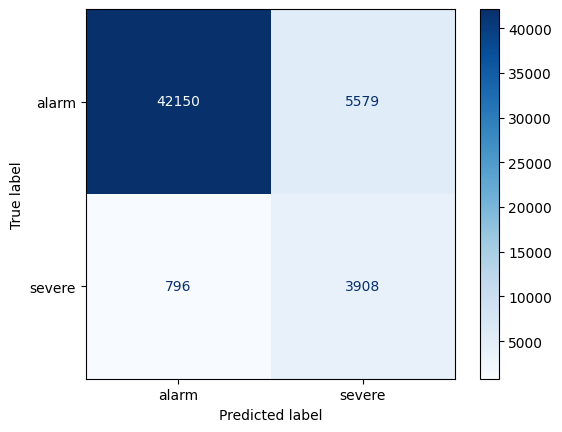

In [15]:
# Plota a matriz de confusão
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(y_c2_test, y_pred, display_labels=target_names_c2, cmap=plt.cm.Blues)

/home/gabriel/Documents/UFRGS/2025-2/ML/TF/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/gabriel/Documents/UFRGS/2025-2/ML/TF/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


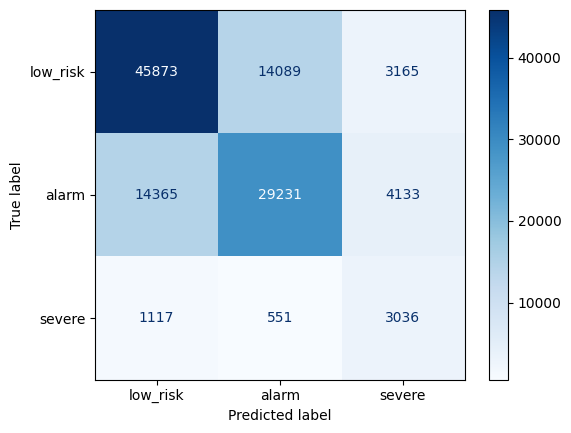

In [16]:
X_test = X_test.drop("severity", axis=1)

y_pred_c1 = dt_c1.predict(X_test)

low_risk_indices = (y_pred_c1 == 0)
high_risk_indices = (y_pred_c1 == 1)

# Filtra os exemplos classificados como 'high_risk'
X_test_high_risk = X_test[high_risk_indices]
y_test_high_risk = y_test[high_risk_indices]

y_pred_c2 = dt_c2.predict(X_test_high_risk)

# Plota a matriz de confusão combinada
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

# Combina as previsões dos dois classificadores
y_pred_combined = np.zeros_like(y_pred_c1)
y_pred_combined[low_risk_indices] = 0  # 'low_risk' é mapeado para 0
y_pred_combined[high_risk_indices] = y_pred_c2 + 1  # 'alarm' é 1 e 'severe' é 2
target_names_combined = ["low_risk", "alarm", "severe"]

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_combined, display_labels=target_names_combined, cmap=plt.cm.Blues)

In [17]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred_combined, target_names=target_names_combined)
print(report)

              precision    recall  f1-score   support

    low_risk       0.75      0.73      0.74     63127
       alarm       0.67      0.61      0.64     47729
      severe       0.29      0.65      0.40      4704

    accuracy                           0.68    115560
   macro avg       0.57      0.66      0.59    115560
weighted avg       0.70      0.68      0.68    115560

